In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import soundfile as sf
import librosa

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#from pydub import AudioSegment
#from pyannote.audio.utils.signal import Binarize, Peak
#from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline

#Specify path to codec exe used by pydub
#AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [2]:
one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models


In [3]:
#[ee.pyannote_extract_directory(model,down_sampled_dir,embedding_dir,'020322_embeddings_testreadings', save=True) for model in emb_models]
[ee.pyannote_extract_directory(model,two_samp_toy_dir,embedding_dir,'', save=False) for model in emb_models]


Processing008.wav
Done


In [3]:
#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb_down = {model:ee.resample_data(emb,1) for model, emb in all_embs.items()}


In [4]:
#perpexity = 30, init='random',learning_rate=200
#emb_tsne_def = {model:dr.run_tsne(ed) for model, ed in emb_down.items()}

#**perpexity = n/100**, init='random',learning_rate=200
#emb_tsne_1pp = {model:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100), init='random',learning_rate=200) for model, ed in emb_down.items()}

#perpexity = 30, **init='pca'**,learning_rate=200
#emb_tsne_pca = {model:dr.run_tsne(ed, init='pca') for model, ed in emb_down.items()}

#**multiscale: perpexity = 30, **init='pca'**,learning_rate=200**
#emb_tsne_pca = {model:dr.run_tsne(ed, init='pca') for model, ed in emb_down.items()}


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
#perpexity = 30, init='random',learning_rate=200
emb_tsne_def = {model:dr.run_tsne(ed) for model, ed in emb_down.items()}

#**perpexity = n/100**, init='random',learning_rate=200
emb_tsne_1pp = {model:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100)) for model, ed in emb_down.items()}

#perpexity = 30, **init='pca'**,learning_rate=200
emb_tsne_pca = {model:dr.run_tsne(ed, init='pca') for model, ed in emb_down.items()}

#**multiscale: perpexity = n/100, **init='pca'**,learning_rate=200**
#should be perplexity = n/100 when n/100>>30
emb_tsne_multi = {model:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100), init='pca', learning_rate=ed.shape[0]//12) for model, ed in emb_down.items()}

In [21]:
emb_umap = {model:dr.run_umap(ed) for model, ed in emb_down.items()}

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
## try to implement KNN, KNC, CPD metrics to evaluate dim reduc from https://github.com/berenslab/rna-seq-tsne/blob/master/toy-example.ipynb
dist = []

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_def',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_def.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_1pp',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_1pp.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_pca',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_pca.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(),
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),'tsne_multi',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_multi.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),'umap',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_umap.values())
]


dist = pd.DataFrame(dist, index = emb_models*5, columns = ['micro', 'meso', 'macro','dim_reduc'])
#dist = pd.DataFrame(dist, index = emb_models*4, columns = ['knn', 'knc', 'cpd','dim_reduc'])

In [25]:
dist[dist.index == 'emb_ami']

,micro,meso,macro,dim_reduc
emb_ami,0.582513,0.744444,0.549773,tsne_def
emb_ami,0.575393,0.700000,0.346315,tsne_1pp
emb_ami,0.587016,0.688889,0.539939,tsne_pca
emb_ami,0.581361,0.661111,0.594372,tsne_multi
emb_ami,0.506178,0.605556,0.217207,umap


In [26]:
dist[dist.index == 'emb']

,micro,meso,macro,dim_reduc
emb,0.589319,0.705556,0.463336,tsne_def
emb,0.583246,0.705556,0.306435,tsne_1pp
emb,0.590785,0.672222,0.521019,tsne_pca
emb,0.578010,0.655556,0.482634,tsne_multi
emb,0.497382,0.594444,0.196584,umap


In [27]:
dist[dist.index == 'emb_voxceleb']

,micro,meso,macro,dim_reduc
emb_voxceleb,0.337941,0.838889,0.646088,tsne_def
emb_voxceleb,0.333122,0.822222,0.667326,tsne_1pp
emb_voxceleb,0.338507,0.827778,0.602358,tsne_pca
emb_voxceleb,0.332919,0.833333,0.645505,tsne_multi
emb_voxceleb,0.206968,0.622222,0.194252,umap


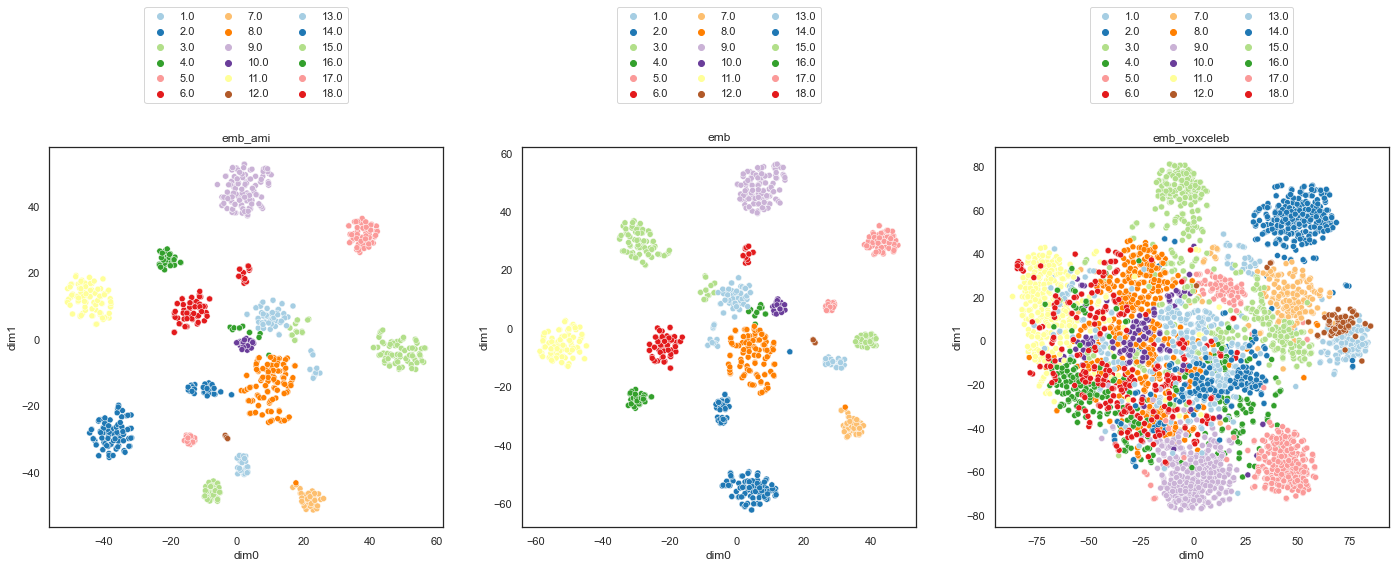

In [44]:
df = emb_tsne_def

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

dy = [0.3,0,0,0,0]
#for model in emb_models:
#    plt.text(0.75,.02+model,'KNN:\nKNC:\nCPD:', transform=plt.gca().transAxes, fontsize=6)
    #plt.text(0.87,.02+model,'{:.2f}\n{:.2f}\n{:.2f}'.format(
    #    quality[i][0], quality[i][1], quality[i][2]), transform=plt.gca().transAxes, fontsize=6)
    #plt.text(0, 1.05, letters[i+1], transform = plt.gca().transAxes, fontsize=8, fontweight='bold')

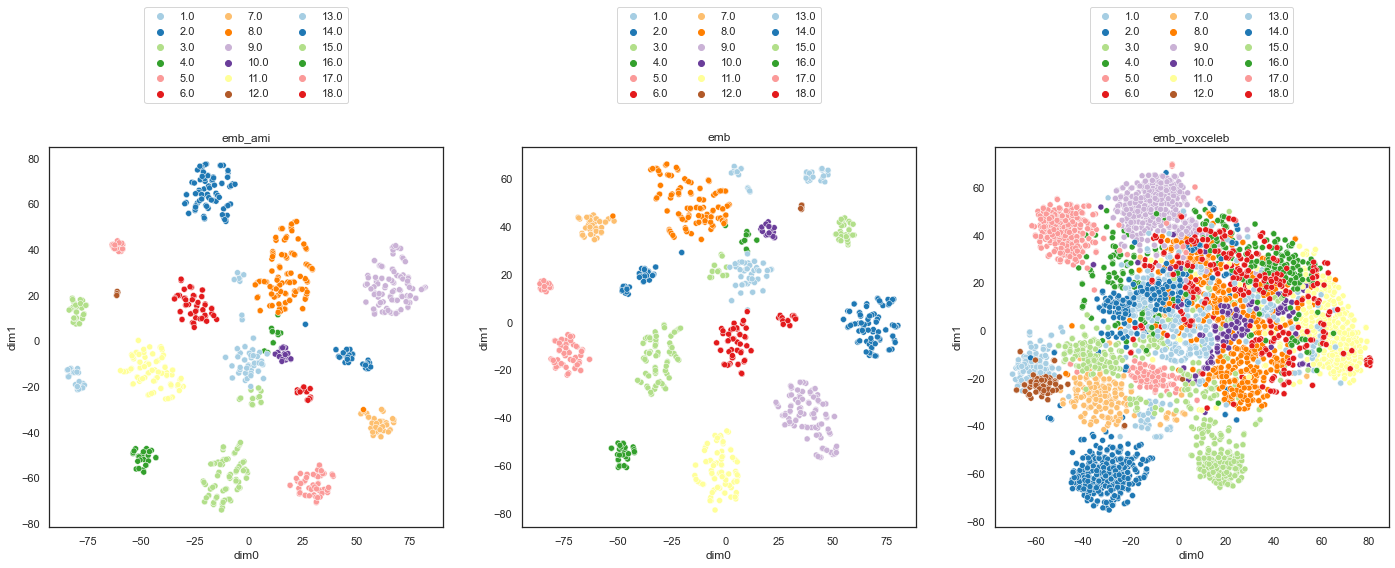

In [43]:
df = emb_tsne_1pp

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

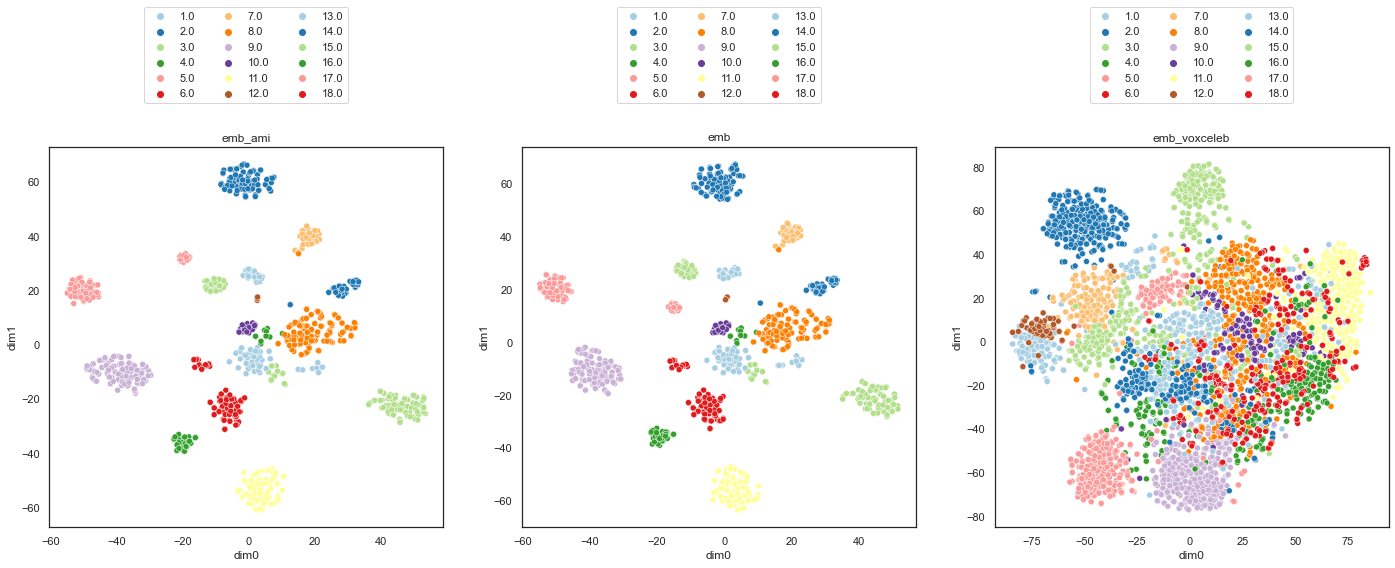

In [41]:
df = emb_tsne_pca

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

In [8]:
#haus_tsne = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_tsne.items()}

#haus_umap = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_umap.items()}

#haus_tsne = {model: haus.where(np.triu(np.ones(haus.shape), k=1).astype(np.bool)) for model, haus in haus_tsne.items()}
#haus_tsne_flat = {model: haus.stack().reset_index() for model, haus in haus_tsne.items()}

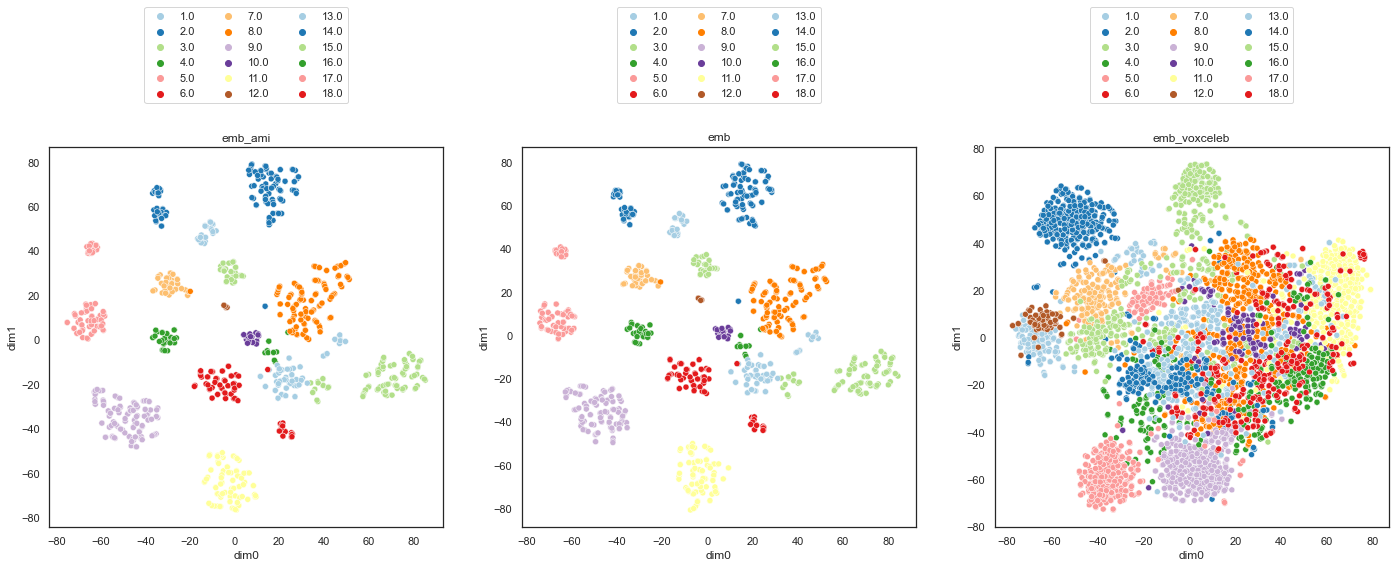

In [40]:
df = emb_tsne_multi

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

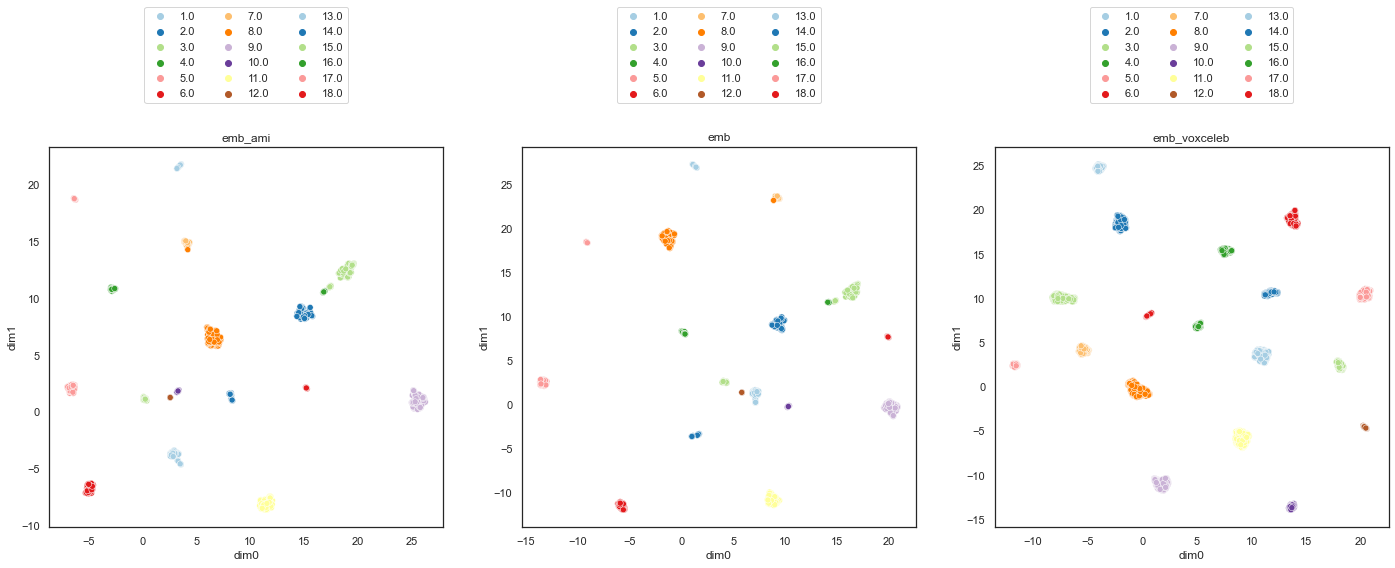

In [42]:
df = emb_umap

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

In [ ]:
sns.set_theme(style="white")

#plot raw points
fig, ax = plt.subplots(ncols=3, figsize=(24,7))
#[sns.scatterplot(x=emb_umap[model].dim0, y=emb_umap[model].dim1, ax=ax[emb_models.index(model)]) for model in emb_models]

#plot raw points color coded by participant
#fig, ax = plt.subplots(1, figsize=(8,7))
#[babycol = sns.color_palette("Paired", len(emb_umap[model].part.unique()))for model in emb_models]
#babycol[12:]=sns.color_palette("hls", 6)
#babycol[10]=(0.3,0.3,0.3)
#babycol[13]=(0.5,0.5,0.5)
[sns.scatterplot(x=emb_umap[model].dim0, y=emb_umap[model].dim1, palette="Paired", hue=emb_umap[model].part_id, ax=ax[emb_models.index(model)]) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1), ncol=3)for model in emb_models]

#fig, ax = plt.subplots()
#haus_tsne_flat[emb_models[0]]
#bins=25
#plt.hist(haus_tsne_flat[emb_models[0]].iloc[:,2],bins,histtype='step')
#plt.hist(haus_tsne_flat[emb_models[1]].iloc[:,2],bins,histtype='step')
#plt.hist(haus_tsne_flat[emb_models[2]].iloc[:,2],bins,histtype='step')

In [5]:
plst = np.arange(18)+1 

#loo is leave one out. Creates a dictionary: {participant_removed:{embedding model:embeddings}} for each participant and embedding model
loo = {'rm' + str(p):
        {mod:
         ed[ed.part_id!=plst[p-1]].reset_index(drop=True) 
         for mod, ed in emb_down.items()
        } 
        for p in plst
       }

In [6]:
#Creates a dictionary: {participant_removed:{embedding model:two-dimension embeddings}} for each participant and embedding model with either tnse or umap
loo_tsne = {rm:
            {mod:dr.run_tsne(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }

loo_umap = {rm:
            {mod:dr.run_umap(ed) 
             for mod, ed in ed_all.items()
            } 
            for rm, ed_all in loo.items()
           }
            

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
#Creates a dictionary: {participant_removed:{embedding model:hausdorf distance}} for each participant and embedding model
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap
loo_haus_tsne = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in e2d_all.items()
             } 
             for rm, e2d_all in loo_tsne.items()
            }

loo_haus_umap = {rm:
             {mod:dm.hausdorff_distances(e2d) 
              for mod, e2d in ed_all.items()
             } 
             for rm, ed_all in loo_umap.items()
            }

#flatten the hausdorf distances for plotting and only get column 2 which has the distances (0 and 1 have the pairs of participants)
loo_haus_tsne_flat = {rm:
                 {mod: haus.stack().reset_index().iloc[:,2]
                  for mod, haus in haus_all.items()
                 } 
                 for rm, haus_all in loo_haus_tsne.items()
                }

Processing row 3, col 13


<function matplotlib.pyplot.show(close=None, block=None)>

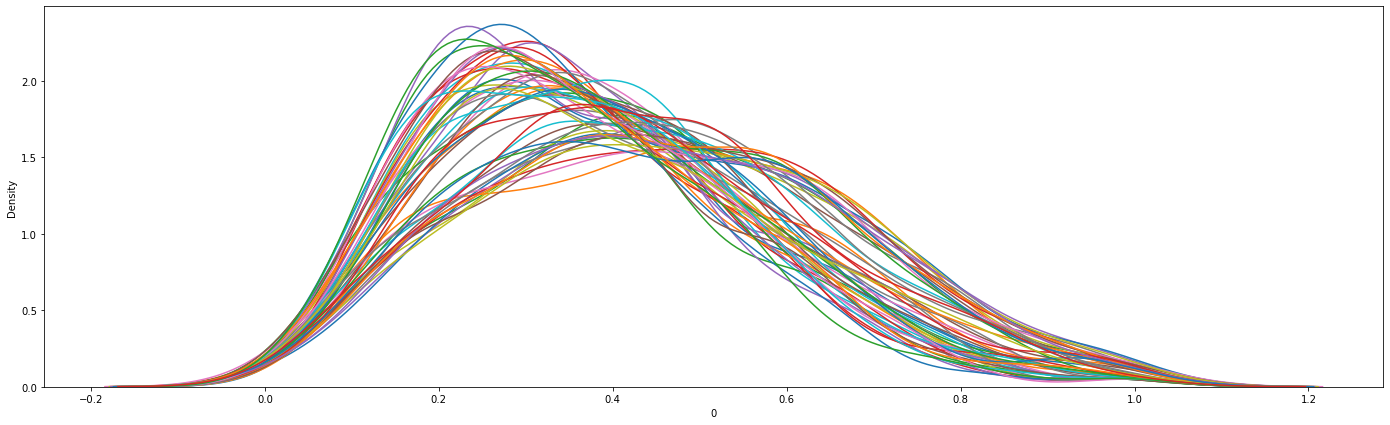

In [83]:
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

#[plt.hist(dist[dist>0], bins) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]
[sns.distplot(dist[dist>0],hist=False) for haus in loo_haus_tsne_flat.values() for dist in haus.values()]

plt.show

In [80]:
a = loo_haus_tsne_flat['rm1']['emb'][loo_haus_tsne_flat['rm1']['emb']>0]
b = loo_haus_tsne_flat['rm2']['emb'][loo_haus_tsne_flat['rm2']['emb']>0]

stats.ttest_ind(a,b, equal_var=False)

Ttest_indResult(statistic=2.0028201331113067, pvalue=0.045702285155521084)

In [72]:
emb_a = {mod:ee.embedding_averager(emb) for mod, emb in all_embs.items()}

cos_emb = {mod:dm.cos_distance(emb) for mod, emb in emb_a.items()}
cos_emb_flat = {mod:cos.stack().reset_index().iloc[:,2] for mod,cos in cos_emb.items()}

Processing row 17, col 17


[<AxesSubplot:xlabel='0', ylabel='Density'>,
 <AxesSubplot:xlabel='0', ylabel='Density'>,
 <AxesSubplot:xlabel='0', ylabel='Density'>]

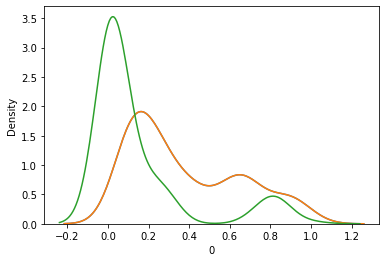

In [73]:
[sns.distplot(cos[cos>0],hist=False) for cos in cos_emb_flat.values()]